# Notebook 2: Global Trends


## Overview

This notebook summarizes global trends across population, emissions, energy use, renewables, and GDP. It focuses on clean totals, clear comparisons, and charts that can be reused in the dashboard.

## 1) Load Data

Connect to the database and prepare common tables for the analyses below.

In [74]:
import sys
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime, timezone
from sqlalchemy import create_engine
from IPython.display import Markdown, display
import matplotlib.pyplot as plt

ROOT_DIR = Path().resolve().parents[0]
sys.path.append(str(ROOT_DIR))

from src.utils.db_utils import (
    DB_USER,
    DB_PASS,
    DB_HOST,
    DB_PORT,
    DB_NAME,
 )

engine = create_engine(f"postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}")


## 2) Global KPIs

Compute headline metrics and per-capita context to frame the global story.

In [76]:

#Data to play around with :D"
start_year = 2000
end_year = 3000
country = "Belgium"

query = f"""
WITH country_data AS (
    SELECT 
        dy.year,
        fcym.population,
        fcym.total_co2_emissions
    FROM "FactCountryYearMetrics" fcym
    JOIN "DimYear" dy ON dy.id = fcym.year_key
    JOIN "DimCountry" dc ON dc.id = fcym.country_key
    WHERE dc.country_name = '{country}'
    AND dy.year >= {start_year}
    AND dy.year <= {end_year}
),
world_data AS (
    SELECT 
        dy.year,
        SUM(fcym.population) AS world_population,
        SUM(fcym.total_co2_emissions) AS world_total_co2
    FROM "FactCountryYearMetrics" fcym
    JOIN "DimYear" dy ON dy.id = fcym.year_key
    GROUP BY dy.year
)
SELECT
    c.year,
    c.total_co2_emissions AS country_total_co2_mt,
    c.population AS country_population,
    w.world_total_co2 AS world_total_co2_mt,
    w.world_population AS world_population
FROM country_data c
JOIN world_data w ON c.year = w.year
ORDER BY c.year;
"""

df = pd.read_sql(query, engine)

df["country_total_co2"] = df["country_total_co2_mt"] * 1_000_000
df["world_total_co2"] = df["world_total_co2_mt"] * 1_000_000

df["per_capita_co2"] = df["country_total_co2"] / df["country_population"]
df["world_per_capita_co2"] = df["world_total_co2"] / df["world_population"]
df["relative_per_capita"] = df["per_capita_co2"] / df["world_per_capita_co2"]

last_row = df.iloc[-1]
year = int(last_row["year"])
relative_ratio = last_row["relative_per_capita"]
total_co2 = last_row["country_total_co2"]
population = last_row["country_population"]

clean_country = country.replace("'", "")
header = f"# {clean_country} CO₂ Per-Capita Overview ({start_year} - {year})"
statement = (
    f"**Average person in {clean_country} emits:** {relative_ratio:.2f} × the world average\n\n"
    f"Total CO₂: {total_co2:,.0f} tons\n"
    f"Population: {population:,.0f}"
)

display(Markdown(header))
display(Markdown(statement))

df_display = df[["year", "country_total_co2", "country_population", "per_capita_co2", "relative_per_capita"]].copy()
df_display = df_display.rename(columns={
    "year": "Year",
    "country_total_co2": "Total CO₂ (tons)",
    "country_population": "Population",
    "per_capita_co2": "Per-Capita CO₂ (tons/person)",
    "relative_per_capita": "Relative to World"
})

df_display["Total CO₂ (tons)"] = df_display["Total CO₂ (tons)"].map("{:,.0f}".format)
df_display["Population"] = df_display["Population"].map("{:,.0f}".format)
df_display["Per-Capita CO₂ (tons/person)"] = df_display["Per-Capita CO₂ (tons/person)"].map("{:.2f}".format)
df_display["Relative to World"] = df_display["Relative to World"].map("{:.2f}".format)

display(Markdown(df_display.to_markdown(index=False)))

# Belgium CO₂ Per-Capita Overview (2000 - 2024)

**Average person in Belgium emits:** 1.56 × the world average

Total CO₂: 86,646,300 tons
Population: 11,858,610

|   Year | Total CO₂ (tons)   | Population   |   Per-Capita CO₂ (tons/person) |   Relative to World |
|-------:|:-------------------|:-------------|-------------------------------:|--------------------:|
|   2000 | 124,897,700        | 10,251,250   |                          12.18 |                3.05 |
|   2001 | 125,755,500        | 10,286,570   |                          12.23 |                3.06 |
|   2002 | 118,493,000        | 10,332,785   |                          11.47 |                2.87 |
|   2003 | 123,371,200        | 10,376,133   |                          11.89 |                2.88 |
|   2004 | 121,979,100        | 10,421,137   |                          11.7  |                2.75 |
|   2005 | 119,007,900        | 10,478,617   |                          11.36 |                2.6  |
|   2006 | 116,077,300        | 10,547,958   |                          11    |                2.47 |
|   2007 | 112,913,700        | 10,625,700   |                          10.63 |                2.33 |
|   2008 | 114,249,700        | 10,709,973   |                          10.67 |                2.35 |
|   2009 | 107,291,800        | 10,796,493   |                           9.94 |                2.24 |
|   2011 | 104,494,800        | 11,038,264   |                           9.47 |                2    |
|   2012 | 103,014,200        | 11,106,932   |                           9.27 |                1.95 |
|   2013 | 104,359,500        | 11,159,407   |                           9.35 |                1.95 |
|   2014 | 97,780,100         | 11,209,057   |                           8.72 |                1.83 |
|   2015 | 102,416,500        | 11,274,196   |                           9.08 |                1.94 |
|   2016 | 101,351,600        | 11,331,422   |                           8.94 |                1.93 |
|   2017 | 99,769,400         | 11,375,158   |                           8.77 |                1.88 |
|   2018 | 100,458,500        | 11,427,054   |                           8.79 |                1.86 |
|   2019 | 100,313,500        | 11,488,980   |                           8.73 |                1.86 |
|   2020 | 91,927,400         | 11,538,604   |                           7.97 |                1.79 |
|   2021 | 96,021,400         | 11,586,195   |                           8.29 |                1.77 |
|   2022 | 89,676,700         | 11,680,210   |                           7.68 |                1.65 |
|   2023 | 85,730,100         | 11,779,946   |                           7.28 |                1.56 |
|   2024 | 86,646,300         | 11,858,610   |                           7.31 |                1.56 |

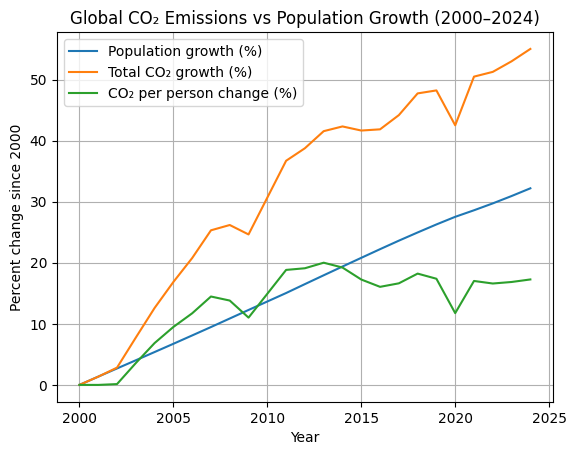

# Global CO₂ vs Population Change (2000–2024)

|   Year | Population    | Total CO₂ (tons)   |   CO₂ per person (tons) |   Population change (%) |   Total CO₂ change (%) |   CO₂ per person change (%) |
|-------:|:--------------|:-------------------|------------------------:|------------------------:|-----------------------:|----------------------------:|
|   2000 | 6,123,229,710 | 24,435,652,100     |                    3.99 |                    0    |                   0    |                        0    |
|   2001 | 6,206,011,879 | 24,764,501,000     |                    3.99 |                    1.35 |                   1.35 |                       -0.01 |
|   2002 | 6,288,094,326 | 25,126,631,500     |                    4    |                    2.69 |                   2.83 |                        0.13 |
|   2003 | 6,369,997,885 | 26,328,660,300     |                    4.13 |                    4.03 |                   7.75 |                        3.57 |
|   2004 | 6,452,664,985 | 27,514,514,500     |                    4.26 |                    5.38 |                  12.6  |                        6.85 |
|   2005 | 6,535,399,462 | 28,555,007,700     |                    4.37 |                    6.73 |                  16.86 |                        9.49 |
|   2006 | 6,619,162,547 | 29,511,635,900     |                    4.46 |                    8.1  |                  20.77 |                       11.72 |
|   2007 | 6,703,290,391 | 30,622,175,600     |                    4.57 |                    9.47 |                  25.32 |                       14.47 |
|   2008 | 6,788,933,181 | 30,834,202,500     |                    4.54 |                   10.87 |                  26.19 |                       13.81 |
|   2009 | 6,874,648,938 | 30,456,884,200     |                    4.43 |                   12.27 |                  24.64 |                       11.02 |
|   2011 | 7,044,478,205 | 33,405,805,400     |                    4.74 |                   15.05 |                  36.71 |                       18.83 |
|   2012 | 7,133,866,143 | 33,906,719,300     |                    4.75 |                   16.5  |                  38.76 |                       19.1  |
|   2013 | 7,222,446,927 | 34,590,245,000     |                    4.79 |                   17.95 |                  41.56 |                       20.01 |
|   2014 | 7,310,240,157 | 34,779,360,200     |                    4.76 |                   19.39 |                  42.33 |                       19.22 |
|   2015 | 7,397,434,864 | 34,614,911,900     |                    4.68 |                   20.81 |                  41.66 |                       17.26 |
|   2016 | 7,484,271,894 | 34,663,397,900     |                    4.63 |                   22.23 |                  41.86 |                       16.06 |
|   2017 | 7,569,562,671 | 35,231,884,300     |                    4.65 |                   23.62 |                  44.18 |                       16.63 |
|   2018 | 7,651,896,272 | 36,101,627,000     |                    4.72 |                   24.97 |                  47.74 |                       18.23 |
|   2019 | 7,732,297,251 | 36,221,179,500     |                    4.68 |                   26.28 |                  48.23 |                       17.38 |
|   2020 | 7,808,777,424 | 34,824,328,200     |                    4.46 |                   27.53 |                  42.51 |                       11.75 |
|   2021 | 7,874,433,997 | 36,772,674,700     |                    4.67 |                   28.6  |                  50.49 |                       17.02 |
|   2022 | 7,943,529,603 | 36,963,047,600     |                    4.65 |                   29.73 |                  51.27 |                       16.6  |
|   2023 | 8,017,248,810 | 37,386,108,300     |                    4.66 |                   30.93 |                  53    |                       16.85 |
|   2024 | 8,094,713,939 | 37,881,703,100     |                    4.68 |                   32.2  |                  55.03 |                       17.27 |

In [77]:
start_year = 2000
end_year = 2024

query = f"""
SELECT
    dy.year,
    SUM(fcym.population) AS population,
    SUM(fcym.total_co2_emissions) * 1000000 AS total_co2_tons
FROM "FactCountryYearMetrics" fcym
JOIN "DimYear" dy ON dy.id = fcym.year_key
WHERE dy.year BETWEEN {start_year} AND {end_year}
GROUP BY dy.year
ORDER BY dy.year;
"""

df = pd.read_sql(query, engine)

df["co2_per_person"] = df["total_co2_tons"] / df["population"]

base_population = df.loc[df["year"] == start_year, "population"].values[0]
base_co2 = df.loc[df["year"] == start_year, "total_co2_tons"].values[0]
base_per_person = df.loc[df["year"] == start_year, "co2_per_person"].values[0]

df["population_change_pct"] = (df["population"] - base_population) / base_population * 100
df["co2_change_pct"] = (df["total_co2_tons"] - base_co2) / base_co2 * 100
df["per_person_change_pct"] = (df["co2_per_person"] - base_per_person) / base_per_person * 100

plt.figure()

plt.plot(df["year"], df["population_change_pct"], label="Population growth (%)")
plt.plot(df["year"], df["co2_change_pct"], label="Total CO₂ growth (%)")
plt.plot(df["year"], df["per_person_change_pct"], label="CO₂ per person change (%)")

plt.title("Global CO₂ Emissions vs Population Growth (2000–2024)")
plt.xlabel("Year")
plt.ylabel("Percent change since 2000")
plt.legend()
plt.grid()

plt.show()

header = f"# Global CO₂ vs Population Change ({start_year}–{end_year})"
display(Markdown(header))

df_display = df[[
    "year",
    "population",
    "total_co2_tons",
    "co2_per_person",
    "population_change_pct",
    "co2_change_pct",
    "per_person_change_pct"
]].copy()

df_display = df_display.rename(columns={
    "year": "Year",
    "population": "Population",
    "total_co2_tons": "Total CO₂ (tons)",
    "co2_per_person": "CO₂ per person (tons)",
    "population_change_pct": "Population change (%)",
    "co2_change_pct": "Total CO₂ change (%)",
    "per_person_change_pct": "CO₂ per person change (%)"
})

df_display["Population"] = df_display["Population"].map("{:,.0f}".format)
df_display["Total CO₂ (tons)"] = df_display["Total CO₂ (tons)"].map("{:,.0f}".format)
df_display["CO₂ per person (tons)"] = df_display["CO₂ per person (tons)"].map("{:.2f}".format)
df_display["Population change (%)"] = df_display["Population change (%)"].map("{:.2f}".format)
df_display["Total CO₂ change (%)"] = df_display["Total CO₂ change (%)"].map("{:.2f}".format)
df_display["CO₂ per person change (%)"] = df_display["CO₂ per person change (%)"].map("{:.2f}".format)

display(Markdown(df_display.to_markdown(index=False)))


## 3) Time Series

Trend lines for key indicators by year, including scenario comparisons where available.

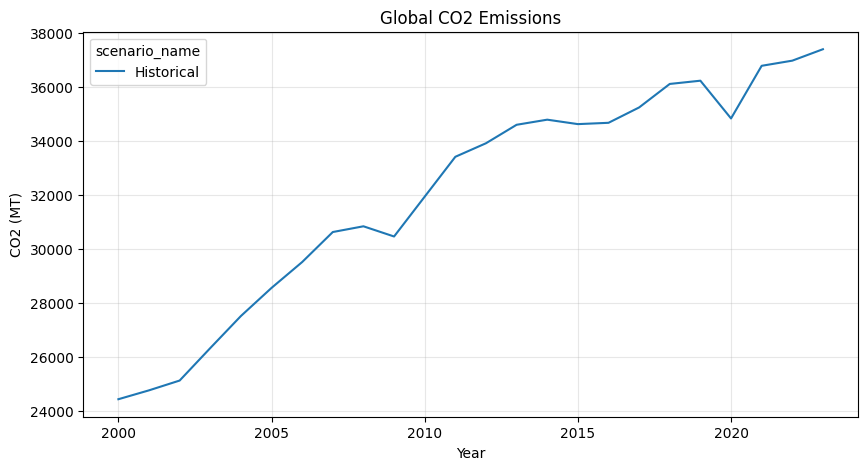

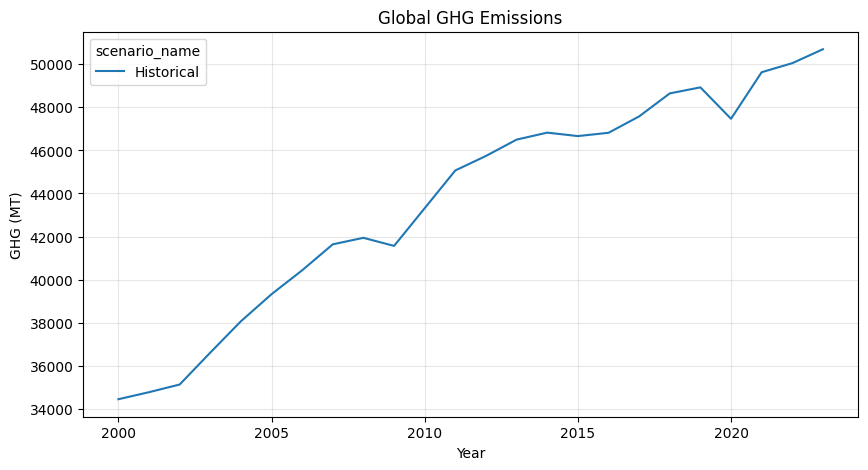

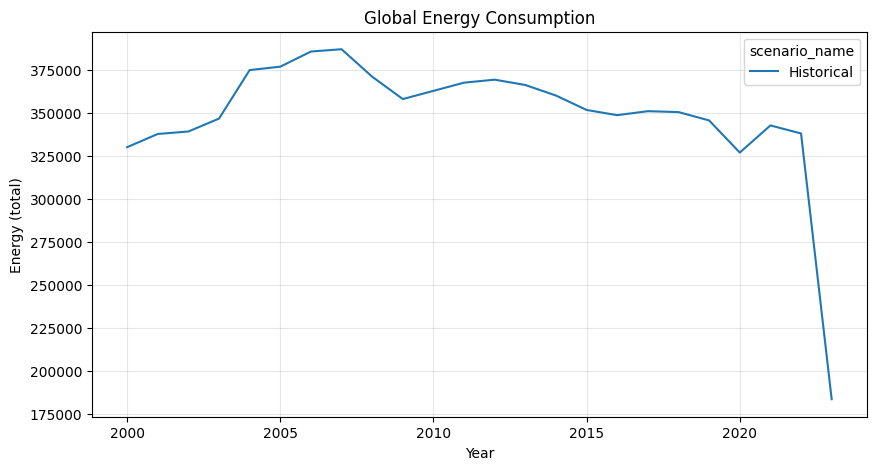

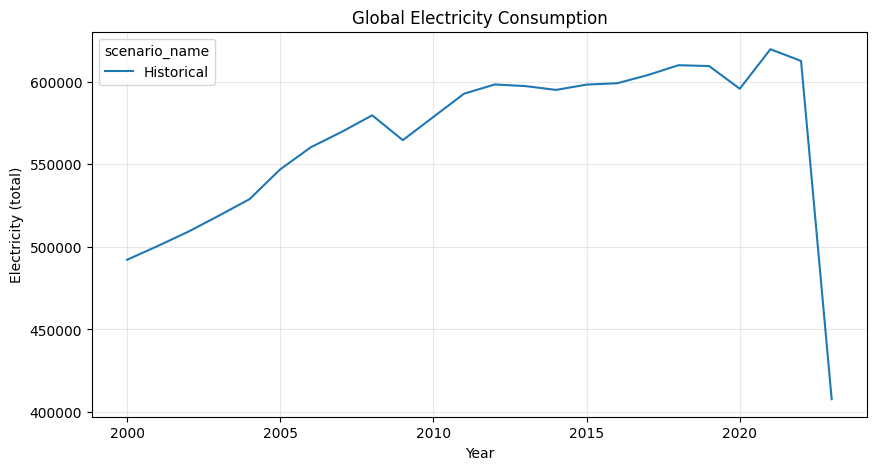

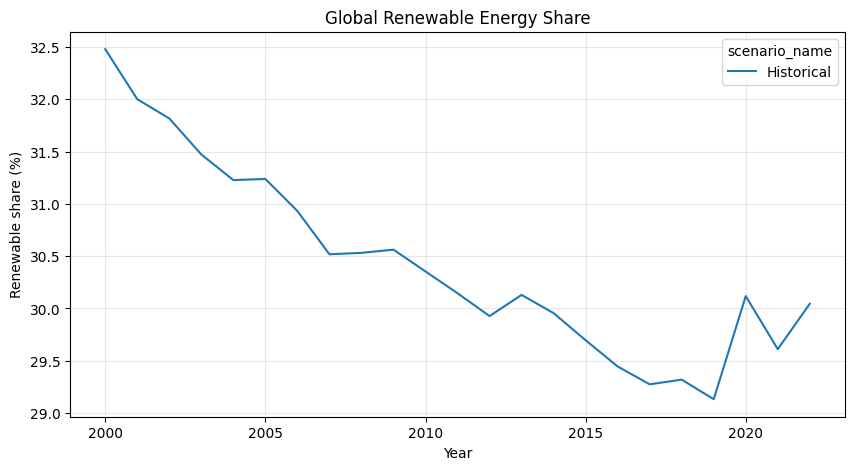

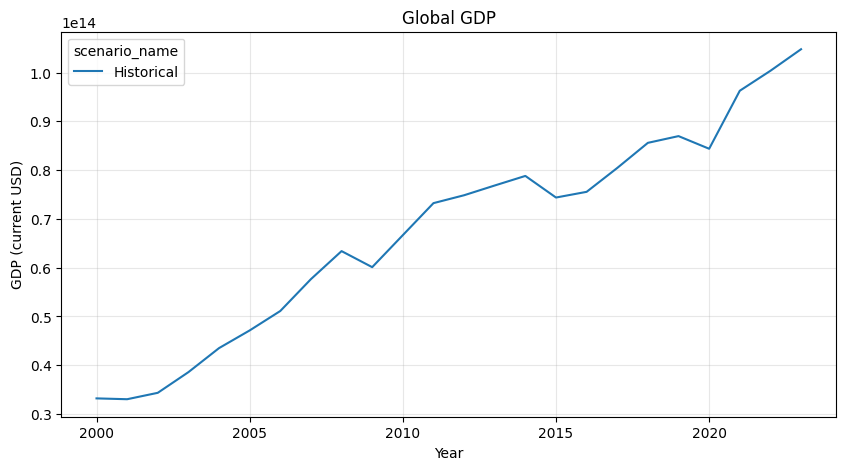

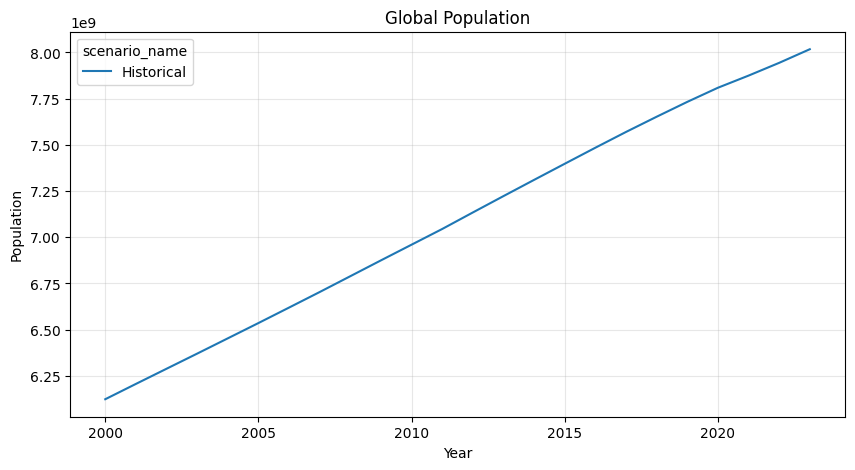

In [79]:
start_year = 2000
end_year = 2023

query = f"""
SELECT
    dy.year,
    ds.scenario_name,
    SUM(fcym.population) AS population,
    SUM(fcym.total_co2_emissions) AS total_co2_mt,
    SUM(fcym.total_ghg_emissions) AS total_ghg_mt,
    SUM(fcym.energy_consumption_total) AS energy_total,
    SUM(fcym.electricity_consumption) AS electricity_total,
    AVG(fcym.renewable_energy_share) AS renewable_share,
    SUM(fcym.gdp) AS gdp_total
FROM "FactCountryYearMetrics" fcym
JOIN "DimYear" dy ON dy.id = fcym.year_key
JOIN "DimScenario" ds ON ds.id = fcym.scenario_key
WHERE dy.year BETWEEN {start_year} AND {end_year}
GROUP BY dy.year, ds.scenario_name
ORDER BY dy.year, ds.scenario_name;
"""

df_ts = pd.read_sql(query, engine)

def plot_metric(df, value_col, ylabel, title):
    pivot = df.pivot(index="year", columns="scenario_name", values=value_col)
    ax = pivot.plot(figsize=(10, 5))
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    plt.show()

plot_metric(df_ts, "total_co2_mt", "CO2 (MT)", "Global CO2 Emissions")
plot_metric(df_ts, "total_ghg_mt", "GHG (MT)", "Global GHG Emissions")
plot_metric(df_ts, "energy_total", "Energy (total)", "Global Energy Consumption")
plot_metric(df_ts, "electricity_total", "Electricity (total)", "Global Electricity Consumption")
plot_metric(df_ts, "renewable_share", "Renewable share (%)", "Global Renewable Energy Share")
plot_metric(df_ts, "gdp_total", "GDP (current USD)", "Global GDP")
plot_metric(df_ts, "population", "Population", "Global Population")

## 4) By Region

Regional rollups to show how global totals break down geographically.

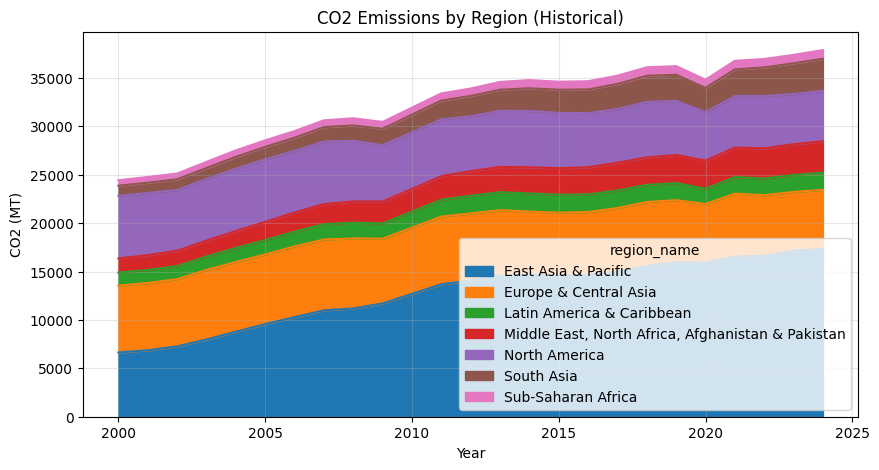

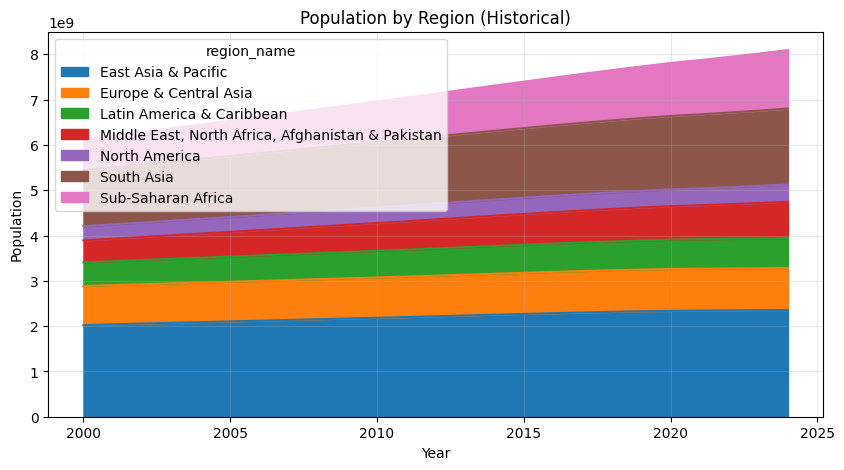

In [80]:
start_year = 2000
end_year = 2024

scenarios = pd.read_sql('SELECT scenario_name FROM "DimScenario" ORDER BY scenario_name;', engine)
if "Baseline" in scenarios["scenario_name"].values:
    scenario_name = "Baseline"
else:
    scenario_name = scenarios["scenario_name"].iloc[0]

query = f"""
SELECT
    dy.year,
    dr.region_name,
    SUM(fcym.total_co2_emissions) AS total_co2_mt,
    SUM(fcym.population) AS population,
    AVG(fcym.renewable_energy_share) AS renewable_share
FROM "FactCountryYearMetrics" fcym
JOIN "DimYear" dy ON dy.id = fcym.year_key
JOIN "DimCountry" dc ON dc.id = fcym.country_key
JOIN "DimRegion" dr ON dr.id = dc.region_key
JOIN "DimScenario" ds ON ds.id = fcym.scenario_key
WHERE dy.year BETWEEN {start_year} AND {end_year}
  AND ds.scenario_name = '{scenario_name}'
GROUP BY dy.year, dr.region_name
ORDER BY dy.year, dr.region_name;
"""

df_region = pd.read_sql(query, engine)

region_pivot = df_region.pivot(index="year", columns="region_name", values="total_co2_mt")
ax = region_pivot.plot.area(figsize=(10, 5))
ax.set_title(f"CO2 Emissions by Region ({scenario_name})")
ax.set_xlabel("Year")
ax.set_ylabel("CO2 (MT)")
ax.grid(True, alpha=0.3)
plt.show()

region_pop = df_region.pivot(index="year", columns="region_name", values="population")
ax = region_pop.plot.area(figsize=(10, 5))
ax.set_title(f"Population by Region ({scenario_name})")
ax.set_xlabel("Year")
ax.set_ylabel("Population")
ax.grid(True, alpha=0.3)
plt.show()

## 5) Emissions by Sector

Sector aggregation for the latest year and long-run composition over time.

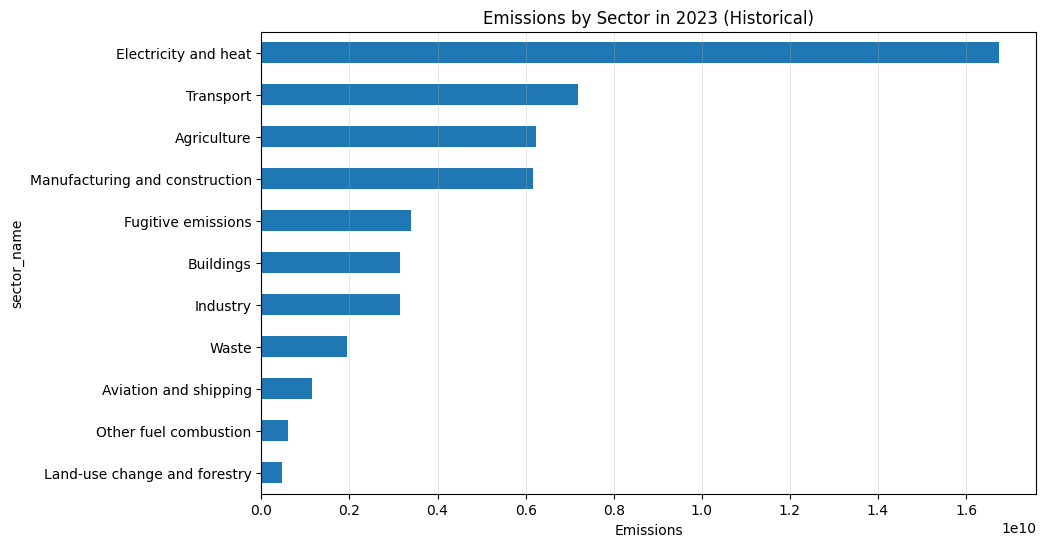

In [82]:
start_year = 2000
end_year = 2024

scenarios = pd.read_sql('SELECT scenario_name FROM "DimScenario" ORDER BY scenario_name;', engine)
if "Baseline" in scenarios["scenario_name"].values:
    scenario_name = "Baseline"
else:
    scenario_name = scenarios["scenario_name"].iloc[0]

query = f"""
SELECT
    dy.year,
    ds.scenario_name,
    dse.sector_name,
    SUM(fse.emissions) AS emissions
FROM "FactSectorEmissions" fse
JOIN "DimYear" dy ON dy.id = fse.year_key
JOIN "DimSector" dse ON dse.id = fse.sector_key
JOIN "DimScenario" ds ON ds.id = fse.scenario_key
WHERE dy.year BETWEEN {start_year} AND {end_year}
  AND ds.scenario_name = '{scenario_name}'
GROUP BY dy.year, ds.scenario_name, dse.sector_name
ORDER BY dy.year, dse.sector_name;
"""

df_sector = pd.read_sql(query, engine)

latest_year = int(df_sector["year"].max())
latest = df_sector[df_sector["year"] == latest_year]

sector_totals = latest.groupby("sector_name")["emissions"].sum().sort_values()
ax = sector_totals.plot.barh(figsize=(10, 6))
ax.set_title(f"Emissions by Sector in {latest_year} ({scenario_name})")
ax.set_xlabel("Emissions")
ax.grid(True, axis="x", alpha=0.3)
plt.show()

sector_pivot = df_sector.pivot_table(index="year", columns="sector_name", values="emissions", aggfunc="sum")
ax.set_title(f"Emissions by Sector Over Time ({scenario_name})")
ax.set_xlabel("Year")
ax.set_ylabel("Emissions")
ax.grid(True, alpha=0.3)
plt.show()

## 6) Scenario Analysis

Compare CO2, GHG, energy, and renewables across scenarios.

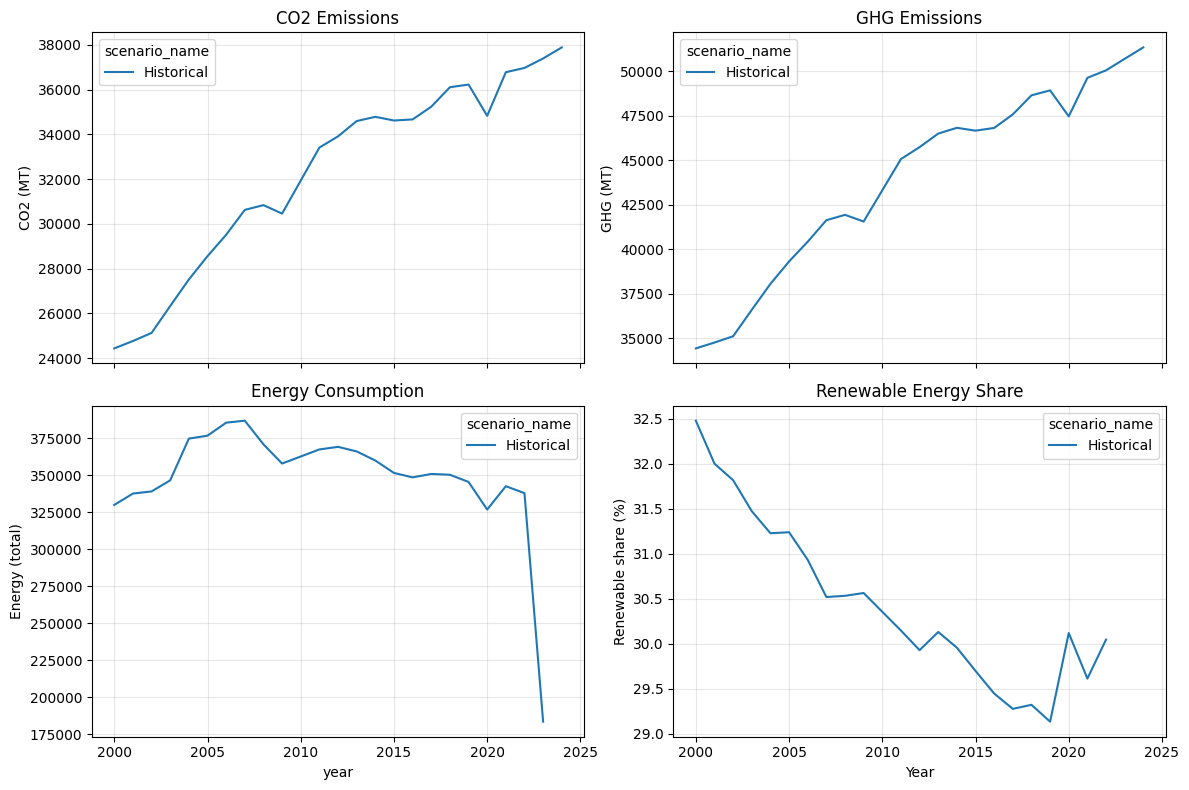

In [84]:
start_year = 2000
end_year = 2024

query = f"""
SELECT
    dy.year,
    ds.scenario_name,
    SUM(fcym.total_co2_emissions) AS total_co2_mt,
    SUM(fcym.total_ghg_emissions) AS total_ghg_mt,
    SUM(fcym.energy_consumption_total) AS energy_total,
    AVG(fcym.renewable_energy_share) AS renewable_share
FROM "FactCountryYearMetrics" fcym
JOIN "DimYear" dy ON dy.id = fcym.year_key
JOIN "DimScenario" ds ON ds.id = fcym.scenario_key
WHERE dy.year BETWEEN {start_year} AND {end_year}
GROUP BY dy.year, ds.scenario_name
ORDER BY dy.year, ds.scenario_name;
"""

df_scen = pd.read_sql(query, engine)

metrics = [
    ("total_co2_mt", "CO2 (MT)", "CO2 Emissions"),
    ("total_ghg_mt", "GHG (MT)", "GHG Emissions"),
    ("energy_total", "Energy (total)", "Energy Consumption"),
    ("renewable_share", "Renewable share (%)", "Renewable Energy Share"),
 ]

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.ravel()

for ax, (col, ylabel, title) in zip(axes, metrics):
    pivot = df_scen.pivot(index="year", columns="scenario_name", values=col)
    pivot.plot(ax=ax)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Year")
plt.tight_layout()
plt.show()

## 7) Ratios and Context

Derived metrics such as carbon intensity and regional renewables versus global.

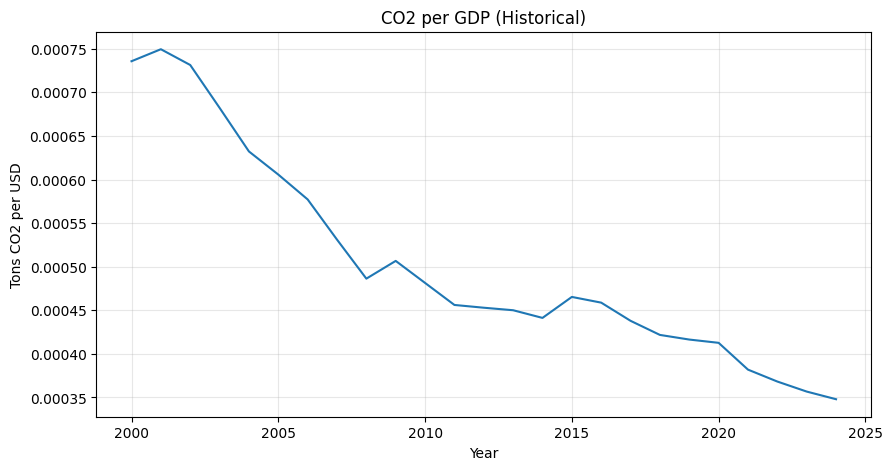

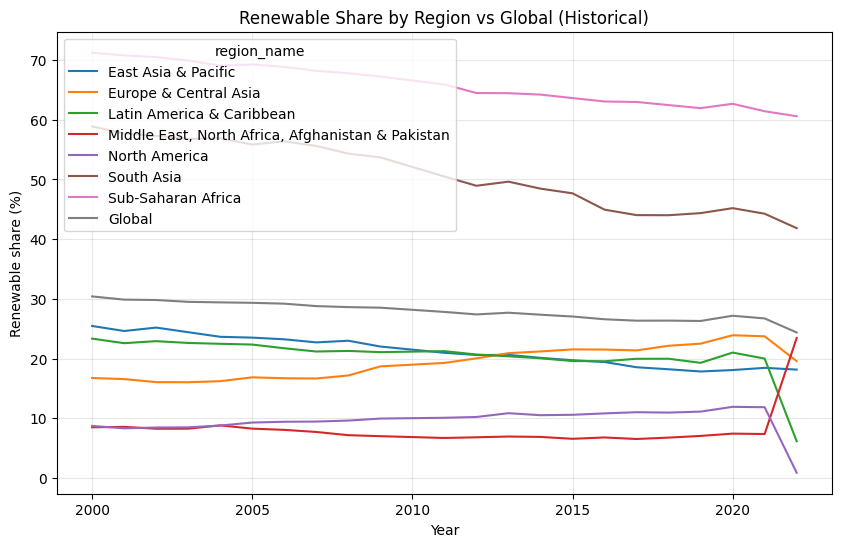

In [86]:
start_year = 2000
end_year = 2024

scenarios = pd.read_sql('SELECT scenario_name FROM "DimScenario" ORDER BY scenario_name;', engine)
if "Baseline" in scenarios["scenario_name"].values:
    scenario_name = "Baseline"
else:
    scenario_name = scenarios["scenario_name"].iloc[0]

query = f"""
SELECT
    dy.year,
    SUM(fcym.total_co2_emissions) AS total_co2_mt,
    SUM(fcym.gdp) AS gdp_total,
    AVG(fcym.renewable_energy_share) AS renewable_share
FROM "FactCountryYearMetrics" fcym
JOIN "DimYear" dy ON dy.id = fcym.year_key
JOIN "DimScenario" ds ON ds.id = fcym.scenario_key
WHERE dy.year BETWEEN {start_year} AND {end_year}
  AND ds.scenario_name = '{scenario_name}'
GROUP BY dy.year
ORDER BY dy.year;
"""

df_ratio = pd.read_sql(query, engine)

df_ratio["co2_per_gdp"] = (df_ratio["total_co2_mt"] * 1_000_000) / df_ratio["gdp_total"]

plt.figure(figsize=(10, 5))
plt.plot(df_ratio["year"], df_ratio["co2_per_gdp"])
plt.title(f"CO2 per GDP ({scenario_name})")
plt.xlabel("Year")
plt.ylabel("Tons CO2 per USD")
plt.grid(True, alpha=0.3)
plt.show()

query = f"""
SELECT
    dy.year,
    dr.region_name,
    AVG(fcym.renewable_energy_share) AS renewable_share
FROM "FactCountryYearMetrics" fcym
JOIN "DimYear" dy ON dy.id = fcym.year_key
JOIN "DimCountry" dc ON dc.id = fcym.country_key
JOIN "DimRegion" dr ON dr.id = dc.region_key
JOIN "DimScenario" ds ON ds.id = fcym.scenario_key
WHERE dy.year BETWEEN {start_year} AND {end_year}
  AND ds.scenario_name = '{scenario_name}'
GROUP BY dy.year, dr.region_name
ORDER BY dy.year, dr.region_name;
"""

df_region_ren = pd.read_sql(query, engine)

global_avg = df_region_ren.groupby("year")["renewable_share"].mean().rename("Global")
region_pivot = df_region_ren.pivot(index="year", columns="region_name", values="renewable_share")
region_pivot["Global"] = global_avg

ax = region_pivot.plot(figsize=(10, 6))
ax.set_title(f"Renewable Share by Region vs Global ({scenario_name})")
ax.set_xlabel("Year")
ax.set_ylabel("Renewable share (%)")
ax.grid(True, alpha=0.3)
plt.show()

## 8) Notes and Observations

Capture notable spikes, drops, and data issues, plus candidate KPIs for dashboard cards.